## Introduction
Greetings from the Kaggle bot! This is an automatically-generated kernel with starter code demonstrating how to read in the data and begin exploring. If you're inspired to dig deeper, click the blue "Fork Notebook" button at the top of this kernel to begin editing.

## Exploratory Analysis
To begin this exploratory analysis, first import libraries and define functions for plotting the data using `matplotlib`. Depending on the data, not all plots will be made. (Hey, I'm just a simple kerneling bot, not a Kaggle Competitions Grandmaster!)

In [32]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets
import pathlib

import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim


There is 0 csv file in the current version of the dataset:


In [22]:
print(os.listdir('../input'))

['x_ray_v3']


The next hidden code cells define functions for plotting data. Click on the "Code" button in the published kernel to reveal the hidden code.

In [23]:
# Distribution graphs (histogram/bar graph) of column data
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()


In [24]:
# Correlation matrix
def plotCorrelationMatrix(df, graphWidth):
    filename = df.dataframeName
    df = df.dropna('columns') # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix for {filename}', fontsize=15)
    plt.show()


In [25]:
# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna('columns')
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()


In [26]:
transform = transforms.Compose([
    transforms.ToTensor()
])
data = datasets.ImageFolder('../input/x_ray_v3/content/x_ray/train',transform=transform)
dataloader = torch.utils.data.DataLoader(data, batch_size=64, shuffle=False)
images, labels = iter(dataloader).next()
numpy_images = images.numpy()
per_image_mean = np.mean(numpy_images, axis=(2,3)) 
per_image_std = np.std(numpy_images, axis=(2,3)) 
pop_channel_mean = np.mean(per_image_mean, axis=0) 
pop_channel_std = np.mean(per_image_std, axis=0) 
mean=(pop_channel_mean )
std=(pop_channel_std)
print("mean",mean)
print("std",std)

mean [0.5144674 0.5144674 0.5144674]
std [0.22294785 0.22294785 0.22294785]


In [27]:
batch_size = 20
# percentage of training set to use as validation and test
valid_size = 0.166
test_size=0.16

# We are keeping minimalistic transforms
# To get preserve effects in the xrays as much as possible
train_transform = transforms.Compose([
    transforms.RandomRotation(10, expand=True),
    transforms.Resize(256),
    transforms.ToTensor()
])

valid_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.ToTensor()
])   
    
test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.ToTensor(),
])
    

# Setting Data Sets for Train, Test, Validation Generators
train_data = datasets.ImageFolder(
    '../input/x_ray_v3/content/x_ray/train',
    transform=train_transform
)

valid_data = datasets.ImageFolder(
    '../input/x_ray_v3/content/x_ray/validation',
    transform=valid_transform
)

test_data = datasets.ImageFolder(
    '../input/x_ray_v3/content/x_ray/test',
    transform=test_transform
)


In [28]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

In [29]:
# Printing out the classes and assigned indexes

classes_to_idx = train_data.class_to_idx.items()
classes = []

print("--Classes & Numerical Labels--")
for key, value in classes_to_idx:
    print(value, key)
    classes.append(key)

print("\n", "No_of_classes: ", len(classes))

--Classes & Numerical Labels--
0 Atelectasis
1 Cardiomegaly
2 Edema
3 Effusion
4 Emphysema
5 No Finding
6 Nodule
7 Pleural_Thickening

 No_of_classes:  8


In [ ]:
def visualize(loader, classes, num_of_image=5, fig_size=(25, 5)):
    images, labels = next(iter(loader))
    
    fig = plt.figure(figsize=fig_size)
    for idx in range(num_of_image):
        ax = fig.add_subplot(1, 5, idx + 1, xticks=[], yticks=[])

        img = images[idx]
        npimg = img.numpy()
        img = np.transpose(npimg, (1, 2, 0))  
        ax.imshow(img, cmap='gray')
        ax.set_title(classes[labels[idx]])

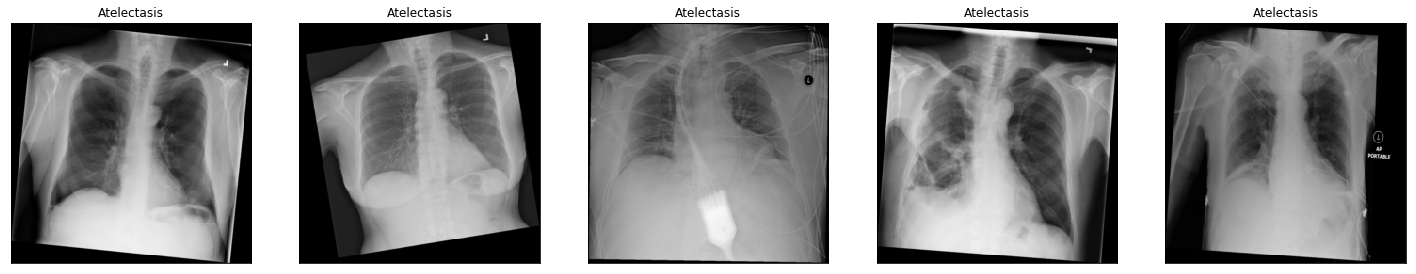

In [30]:
visualize(train_loader, classes)


In [33]:

def milan(input, beta=-0.25):
    '''
    Applies the Mila function element-wise:
    Mila(x) = x * tanh(softplus(1 + β)) = x * tanh(ln(1 + exp(x+β)))
    See additional documentation for mila class.
    '''
    return input * torch.tanh(F.softplus(input+beta))

class mila(nn.Module):
    '''
    Applies the Mila function element-wise:
    Mila(x) = x * tanh(softplus(1 + β)) = x * tanh(ln(1 + exp(x+β)))
    Shape:
        - Input: (N, *) where * means, any number of additional
          dimensions
        - Output: (N, *), same shape as the input
    Examples:
        >>> m = mila(beta=1.0)
        >>> input = torch.randn(2)
        >>> output = m(input)
    '''
    def __init__(self, beta=-0.25):
        '''
        Init method.
        '''
        super().__init__()
        self.beta = beta

    def forward(self, input):
        '''
        Forward pass of the function.
        '''
        return milan(input, self.beta)

In [35]:
class fc(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2048, 500)
        self.fc2 = nn.Linear(500, 256)
        self.fc3 = nn.Linear(256, 8)
        self.dropout = nn.Dropout(0.5)
        self.logsoftmax = nn.LogSoftmax(dim=1)
        self.mila = mila()
    def forward(self,x):
        x = x.view(x.size(0), -1)
        x = self.dropout(self.mila(self.fc1(x)))
        x = self.dropout(self.mila(self.fc2(x)))

        x = self.logsoftmax(self.fc3(x))
        return x
#model.fc = fc()

In [ ]:
densenet = models.densenet121(pretrained=True)
print(densenet)

In [ ]:
# Freeze training for all "features" layers
for param in densenet.features.parameters():
    param.requires_grad = False

In [ ]:
#adding the final layer
n_inputs = densenet.classifier[6].in_features
last_layer = nn.Linear(n_inputs, len(classes))

densenet.classifier[6] = last_layer

# if GPU is available, move the model to GPU
if train_on_gpu:
    densenet.cuda()

# check to see that your last layer produces the expected number of outputs
print(densenet.classifier[6].out_features)

In [ ]:

# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer (stochastic gradient descent) and learning rate = 0.001
optimizer = optim.SGD(vgg16.classifier.parameters(), lr=0.001)

In [ ]:
#train the model

Oh, no! There are no automatic insights available for the file types used in this dataset. As your Kaggle kerneler bot, I'll keep working to fine-tune my hyper-parameters. In the meantime, please feel free to try a different dataset.

## Conclusion
This concludes your starter analysis! To go forward from here, click the blue "Fork Notebook" button at the top of this kernel. This will create a copy of the code and environment for you to edit. Delete, modify, and add code as you please. Happy Kaggling!